In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
from matplotlib import gridspec
from scipy import stats, interpolate
import os
from tensorflow.keras import backend as K  

import tqdm



In [2]:
def load (basedir, name, model=None):

    # Import(s)
    from keras.models import load_model

    # Load full pre-trained model or model weights
    if model is None:
        model = load_model(basedir + '{}.h5'.format(name))
    else:
        model.load_weights(basedir + '{}_weights.h5'.format(name))
        pass

    # Load associated training histories
    try:
        history_file = basedir + 'history__{}.json'.format(name)
        with open(history_file, 'r') as f:
            history = json.load(f)
            pass
    except:
        print ("[WARN] Could not find history file {}.") #
        history = None
        pass

    return model, history

In [3]:
def load_data (path, name='dataset', train=None, test=None, signal=None, background=None, sample=None, seed=21, replace=True):
    """
    General script to load data, common to all run scripts.

    Arguments:
        path: The path to the HDF5 file, from which data should be loaded.
        name: Name of the dataset, as stored in the HDF5 file.
        ...

    Returns:
        Tuple of pandas.DataFrame containing the loaded; list of loaded features
        to be used for training; and list of features to be used for mass-
        decorrelation.

    Raises:
        IOError: If no HDF5 file exists at the specified `path`.
        KeyError: If the HDF5 does not contained a dataset named `name`.
        KeyError: If any of the necessary features are not present in the loaded
            dataset.
    """

    # Check(s)
    #assert False not in [train, test, signal, background]
    #if sample: assert 0 < sample and sample < 1.

    # Read data from HDF5 file
    data = pd.read_hdf(path)

    # Subsample signal by x10 for testing: 1E+07 -> 1E+06
    np.random.seed(7)
    try:
        msk_test  = data['train'] == 0
        msk_train = ~msk_test
        msk_bkg = data['signal'] == 0
        msk_sig = ~msk_bkg
        #idx_sig = np.where(msk_sig)[0]
        #idx_sig = np.random.choice(idx_sig, int(msk_sig.sum() * 0.1), replace=False)
        #msk_sig = np.zeros_like(msk_bkg).astype(bool)
        #msk_sig[idx_sig] = True
        #data = data[msk_train | (msk_test & (msk_sig | msk_bkg))]
    except:
        log.warning("Some of the keys ['train', 'signal'] were not present in file {}".format(path))
        pass



    # Define feature collections to use
    features_input = ['Tau21J1', 'Tau21J2', 'Tau32J1', 'Tau32J2']
    features_decorrelation = ['m']

    # Split data
    if train:
        log.info("load_data: Selecting only training data.")
        data = data[data['train']  == 1]
        pass

    if test:
        # log.info("load_data: Selecting only testing data.")
        data = data[data['train']  == 0]
        pass

    if signal:
        log.info("load_data: Selecting only signal data.")
        data = data[data['signal'] == 1]
        pass

    if background:
        log.info("load_data: Selecting only background data.")
        data = data[data['signal'] == 0]
        pass

    if sample:
        log.info("load_data: Selecting a random fraction {:.2f} of data (replace = {}, seed = {}).".format(sample, replace, seed))
        data = data.sample(frac=sample, random_state=seed, replace=False)
        pass

    # Return
    return data, features_input, features_decorrelation


In [4]:
alpha = 0.1

def load_dataT21(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2"]]
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)

    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta", "tau21jOne", "tau21jTwo"]]
    return dataset.to_numpy()

def load_dataT32(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2"]]
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)

    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau3jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau3jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau32jOne"] = dataset["tau3jOne"]/dataset["tau2jOne"]
    dataset["tau32jTwo"] = dataset["tau3jTwo"]/dataset["tau2jTwo"] 
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta", "tau32jOne", "tau32jTwo"]]
    return dataset.to_numpy()

def load_data_more(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2"]]
    
    #Masa ya al cuadrado
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    
    
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)

    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    
    #tau32
    dataset["tau3jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau3jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau32jOne"] = dataset["tau3jOne"]/dataset["tau2jOne"]
    dataset["tau32jTwo"] = dataset["tau3jTwo"]/dataset["tau2jTwo"]   
    
    #pT
    dataset["pT1"] = (input_frame["pxj1"]**2+input_frame["pyj1"]**2)**0.5/1000.
    dataset["pT2"] = (input_frame["pxj2"]**2+input_frame["pyj2"]**2)**0.5/1000.
    dataset["pTjOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["pT2"]
    dataset["pTjTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["pT2"]    
    
    #eta
    dataset["E1"] = ((1000*dataset["pT1"])**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5/1000.
    dataset["E2"] = ((1000*dataset["pT2"])**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5/1000.
    dataset["y1"] = 0.5*np.log((dataset["E1"] + input_frame["pzj1"]/1000.)/(dataset["E1"] - input_frame["pzj1"]/1000.))
    dataset["y2"] = 0.5*np.log((dataset["E2"] + input_frame["pzj2"]/1000.)/(dataset["E2"] - input_frame["pzj2"]/1000.))
    dataset["Dy"] = dataset["y1"]-dataset["y2"]
    
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta", "tau21jOne", "tau21jTwo", "tau32jOne", "tau32jTwo","pTjOne","pTjTwo","Dy"]]
    return dataset.to_numpy()

column_labelsT21 = [
    r"$m_{JJ}$",
    r"$m^{J_1}$",
    "$m^{J_2} - m^{J_1}$",
    r"$\tau_{2,1}^{J_1}$", 
    r"$\tau_{2,1}^{J_2}$",
]

column_labelsT32 = [
    r"$m_{JJ}$",
    r"$m^{J_1}$",
    "$m^{J_2} - m^{J_1}$",
    r"$\tau_{3,2}^{J_1}$", 
    r"$\tau_{3,2}^{J_2}$",
]

In [5]:
original_data=pd.read_hdf("C:/Users/knukl/Desktop/FINAL/input/events_anomalydetection_v2.features.h5")
features_sig=original_data.query("label == 1")
features_bg=original_data.query("label == 0")


features_bg2=pd.read_hdf("C:/Users/knukl/Desktop/FINAL/input/events_anomalydetection_DelphesHerwig_qcd_features.h5")

In [6]:
dataset_bg=load_dataT21(features_bg)
dataset_bg2=load_dataT21(features_bg2)
dataset_sig=load_dataT21(features_sig)

dataset_bgT32=load_dataT32(features_bg)
dataset_bg2T32=load_dataT32(features_bg2)
dataset_sigT32=load_dataT32(features_sig)

C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\259476259.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\259476259.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [7]:
dataset_bg_more=load_data_more(features_bg)
dataset_bg2_more=load_data_more(features_bg2)
dataset_sig_more=load_data_more(features_sig)

C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\259476259.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\259476259.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [8]:
dataset_bg

array([[3.30721939, 0.36961794, 0.52971994, 0.58331666, 0.26323715],
       [3.1076206 , 0.33376126, 0.67729487, 0.78773201, 0.51908614],
       [3.00489527, 0.37264503, 0.30656472, 0.78958448, 0.91180871],
       ...,
       [4.283545  , 0.4848261 , 0.7679949 , 0.71013539, 0.83904146],
       [2.78405802, 0.3835928 , 0.53700979, 0.6447025 , 0.22796556],
       [2.92645683, 0.34226608, 0.39324028, 0.63616232, 0.91674757]])

In [9]:
from sklearn.model_selection import train_test_split

SR_low = 3.3
SR_high = 3.7
test_size = 0.5
EPOCHS=20
batch_size = 200
SB_width = 0.3

def sr_crit(d):
    return (d[:,0] < SR_high) & (d[:,0] >= SR_low)



bg_srsb, bg2_srsb, sig_srsb = sr_crit(dataset_bg_more), sr_crit(dataset_bg2_more), sr_crit(dataset_sig_more)

SR_background_data = dataset_bg[bg_srsb]
SB_background_data = dataset_bg[~bg_srsb]
print(~bg_srsb)

SR_background_sim = dataset_bg2[bg2_srsb]
SB_background_sim = dataset_bg2[~bg2_srsb]

SR_signal = dataset_sig[sig_srsb]
SB_signal = dataset_sig[~sig_srsb]

N_inputs = len(SR_background_data.T) - 1


((SR_background_data, SR_background_data_fortest),
 (SR_background_sim, SR_background_sim_fortest),
 (SB_background_data, SB_background_data_fortest),
 (SB_background_sim, SB_background_sim_fortest),
 ) = [train_test_split(arr, test_size=test_size) for arr in [
    SR_background_data, SR_background_sim,
    SB_background_data, SB_background_sim,
]]

mn,mx = np.percentile(np.concatenate([SB_background_data, SB_background_sim, SR_background_data, 
                                      SR_background_sim]), [1,99], axis=0)

def norm_func(d):
    return (d - mn)/(mx - mn)

Nsig = 1000
Nsig_SB = int(np.round(len(SB_signal)*Nsig/len(SR_signal)))

fmt = '{:>20}:  {}'
print(fmt.format('# signal events', Nsig))
print(fmt.format('signal significance', len(SR_signal[0:Nsig])/len(SR_background_data)**0.5))
print(fmt.format('s/b ratio', len(SR_signal[0:Nsig])/len(SR_background_data)))

n_injections = 20
SR_signals_to_inject = [None] * n_injections
SB_signals_to_inject = [None] * n_injections
signals_to_test = [None] * n_injections

for i in range(n_injections):
    idx = np.isin(range(len(SR_signal)), np.random.choice(SR_signal.shape[0], size=Nsig, replace=False))
    SR_signals_to_inject[i] = SR_signal[idx, :]
    signals_to_test[i] = SR_signal[~idx, :]
    
    idx = np.isin(range(len(SB_signal)), np.random.choice(SB_signal.shape[0], size=Nsig_SB, replace=False))
    SB_signals_to_inject[i] = SB_signal[idx, :]

[False  True  True ...  True  True  True]
     # signal events:  1000
 signal significance:  4.059677443835412
           s/b ratio:  0.016480980947986026


In [10]:
#Next is CWoLa
tpr_pts = np.linspace(0, 1, 10000)
cwola_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in tqdm.tqdm(range(n_injections)):
    
    SR_signal_to_inject = SR_signals_to_inject[i]
    SB_signal_to_inject = SB_signals_to_inject[i]

    signal_to_test = signals_to_test[i]
        
    X_cwola_train = np.concatenate([SR_signal_to_inject, SR_background_data, SB_signal_to_inject, SB_background_data])
    Y_cwola_train = np.concatenate([np.ones(len(SR_signal_to_inject)), np.ones(len(SR_background_data)),
                                    np.zeros(len(SB_signal_to_inject)), np.zeros(len(SB_background_data))])
    
    X_cwola_train, Y_cwola_train = shuffle(X_cwola_train, Y_cwola_train, )

    sbmjj = X_cwola_train[:,0]
    sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))
    
    X_cwola_train = X_cwola_train[sb_crit]
    Y_cwola_train = Y_cwola_train[sb_crit]
    
    w_low = 0.5*(len(SR_signal_to_inject) + len(SR_background_data))/((X_cwola_train[:,0] <= SR_low).sum())
    w_high = 0.5*(len(SR_signal_to_inject) + len(SR_background_data))/((X_cwola_train[:,0] >= SR_high).sum())

    W_cwola_train = np.ones_like(Y_cwola_train)
    W_cwola_train[(Y_cwola_train == 0) & (X_cwola_train[:,0] <= SR_low)] = w_low
    W_cwola_train[(Y_cwola_train == 0) & (X_cwola_train[:,0] >= SR_high)] = w_high
    
    X_cwola_val = np.concatenate([signal_to_test,SR_background_data_fortest])
    Y_cwola_val = np.concatenate([np.ones(len(signal_to_test)),np.zeros(len(SR_background_data_fortest))])
    
    K.clear_session()
    model_cwola = Sequential()
    model_cwola.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_cwola.add(Dense(64, activation='relu'))
    model_cwola.add(Dense(64, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_cwola = model_cwola.fit(X_cwola_train[:,1:], Y_cwola_train, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0, sample_weight=W_cwola_train)

    scores_cwola = model_cwola.predict(X_cwola_val[:,1:],batch_size=batch_size)
        
    fpr_cwola, tpr_cwola, _ = roc_curve(Y_cwola_val, scores_cwola)
    cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)

  0%|          | 0/20 [00:00<?, ?it/s]

675/675 [==============================] - 1s 715us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
  5%|▌         | 1/20 [00:48<15:29, 48.91s/it]

675/675 [==============================] - 1s 727us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 10%|█         | 2/20 [01:36<14:30, 48.34s/it]

675/675 [==============================] - 1s 681us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 15%|█▌        | 3/20 [02:24<13:37, 48.07s/it]

675/675 [==============================] - 1s 667us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 20%|██        | 4/20 [03:11<12:40, 47.51s/it]

675/675 [==============================] - 1s 664us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 25%|██▌       | 5/20 [03:58<11:50, 47.38s/it]

675/675 [==============================] - 0s 647us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 30%|███       | 6/20 [04:45<11:00, 47.20s/it]

675/675 [==============================] - 1s 674us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 35%|███▌      | 7/20 [05:32<10:13, 47.15s/it]

675/675 [==============================] - 0s 652us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 40%|████      | 8/20 [06:18<09:23, 46.95s/it]

675/675 [==============================] - 0s 654us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 45%|████▌     | 9/20 [07:05<08:34, 46.74s/it]

675/675 [==============================] - 1s 667us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 50%|█████     | 10/20 [07:53<07:52, 47.21s/it]

675/675 [==============================] - 0s 658us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 55%|█████▌    | 11/20 [08:40<07:05, 47.24s/it]

675/675 [==============================] - 0s 654us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 60%|██████    | 12/20 [09:27<06:16, 47.09s/it]

675/675 [==============================] - 0s 654us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 65%|██████▌   | 13/20 [10:13<05:28, 46.94s/it]

675/675 [==============================] - 0s 645us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 70%|███████   | 14/20 [11:00<04:40, 46.80s/it]

675/675 [==============================] - 1s 682us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 75%|███████▌  | 15/20 [11:49<03:57, 47.53s/it]

675/675 [==============================] - 1s 670us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 80%|████████  | 16/20 [12:37<03:10, 47.59s/it]

675/675 [==============================] - 0s 656us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 85%|████████▌ | 17/20 [13:24<02:21, 47.33s/it]

675/675 [==============================] - 0s 648us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 90%|█████████ | 18/20 [14:10<01:34, 47.18s/it]

675/675 [==============================] - 0s 653us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 95%|█████████▌| 19/20 [14:57<00:46, 46.99s/it]

675/675 [==============================] - 1s 684us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
100%|██████████| 20/20 [15:46<00:00, 47.33s/it]


In [11]:
# CWoLa
fpr_interp = [None] * len(cwola_rocs)

for i, row in cwola_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

cwola_max = np.nanmax(fpr_interp, axis=0).data
cwola_min = np.nanmin(fpr_interp, axis=0).data
cwola_med = np.median(fpr_interp, axis=0).data
cwola_mean = np.nanmean(fpr_interp, axis=0).data
cwola_std = np.nanstd(fpr_interp, axis=0).data
    
sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
cwola_smean = np.nanmean(sig_interp, axis=0).data
cwola_sstd = np.nanstd(sig_interp, axis=0).data

C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\3456826973.py:11: RuntimeWarning: divide by zero encountered in true_divide
  fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))
c:\Users\knukl\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [12]:
#Now let's optimal CWoLa
ocwola_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in tqdm.tqdm(range(n_injections)):
    SR_signal_to_inject = SR_signals_to_inject[i]
    SB_signal_to_inject = SB_signals_to_inject[i]

    signal_to_test = signals_to_test[i]

    X_ocwola_train = np.concatenate([SR_signal_to_inject, SR_background_data,SR_background_data_fortest])
    Y_ocwola_train = np.concatenate([np.ones(len(SR_signal_to_inject)),np.ones(len(SR_background_data)),np.zeros(len(SR_background_data_fortest))])

    X_ocwola_train, Y_ocwola_train = shuffle(X_ocwola_train, Y_ocwola_train)

    sbmjj = X_ocwola_train[:,0]
    sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))
    
    X_ocwola_train = X_ocwola_train[sb_crit]
    Y_ocwola_train = Y_ocwola_train[sb_crit]

    X_ocwola_val = np.concatenate([signal_to_test,SR_background_data_fortest])
    Y_ocwola_val = np.concatenate([np.ones(len(signal_to_test)),np.zeros(len(SR_background_data_fortest))])


    K.clear_session()
    model_ocwola = Sequential()
    model_ocwola.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    
    model_ocwola.add(Dense(64, activation='relu'))
    model_ocwola.add(Dense(64, activation='relu'))
    model_ocwola.add(Dense(1, activation='sigmoid'))
    model_ocwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist_ocwola = model_ocwola.fit(X_ocwola_train[:,1:], Y_ocwola_train, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0)

    scores_ocwola = model_ocwola.predict(X_ocwola_val[:,1:],batch_size=batch_size)
    
    fpr_ocwola, tpr_ocwola, _ = roc_curve(Y_ocwola_val, scores_ocwola)
    ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)

  0%|          | 0/20 [00:00<?, ?it/s]

675/675 [==============================] - 0s 627us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\887101774.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)
  5%|▌         | 1/20 [00:13<04:13, 13.32s/it]

675/675 [==============================] - 0s 607us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\887101774.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)
 10%|█         | 2/20 [00:26<03:54, 13.01s/it]

675/675 [==============================] - 0s 614us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\887101774.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)
 15%|█▌        | 3/20 [00:38<03:37, 12.80s/it]

675/675 [==============================] - 0s 608us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\887101774.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)
 20%|██        | 4/20 [00:51<03:22, 12.63s/it]

675/675 [==============================] - 0s 636us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\887101774.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)
 25%|██▌       | 5/20 [01:05<03:19, 13.33s/it]

675/675 [==============================] - 1s 681us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\887101774.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)
 30%|███       | 6/20 [01:18<03:05, 13.28s/it]

675/675 [==============================] - 0s 623us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\887101774.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)
 35%|███▌      | 7/20 [01:31<02:50, 13.13s/it]

675/675 [==============================] - 0s 624us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\887101774.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)
 40%|████      | 8/20 [01:44<02:36, 13.02s/it]

675/675 [==============================] - 0s 623us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\887101774.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)
 45%|████▌     | 9/20 [01:56<02:21, 12.88s/it]

675/675 [==============================] - 0s 611us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\887101774.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)
 50%|█████     | 10/20 [02:09<02:07, 12.75s/it]

675/675 [==============================] - 0s 645us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\887101774.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)
 55%|█████▌    | 11/20 [02:24<02:00, 13.42s/it]

675/675 [==============================] - 0s 632us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\887101774.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)
 60%|██████    | 12/20 [02:37<01:47, 13.38s/it]

675/675 [==============================] - 0s 627us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\887101774.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)
 65%|██████▌   | 13/20 [02:50<01:32, 13.18s/it]

675/675 [==============================] - 0s 610us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\887101774.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)
 70%|███████   | 14/20 [03:03<01:18, 13.02s/it]

675/675 [==============================] - 0s 619us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\887101774.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)
 75%|███████▌  | 15/20 [03:15<01:04, 12.83s/it]

675/675 [==============================] - 0s 632us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\887101774.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)
 80%|████████  | 16/20 [03:30<00:53, 13.42s/it]

675/675 [==============================] - 1s 666us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\887101774.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)
 85%|████████▌ | 17/20 [03:43<00:40, 13.47s/it]

675/675 [==============================] - 0s 619us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\887101774.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)
 90%|█████████ | 18/20 [03:56<00:26, 13.23s/it]

675/675 [==============================] - 0s 617us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\887101774.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)
 95%|█████████▌| 19/20 [04:09<00:13, 13.02s/it]

675/675 [==============================] - 0s 615us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\887101774.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)
100%|██████████| 20/20 [04:21<00:00, 13.08s/it]


In [13]:
# optimal CWoLa
tpr_pts = np.linspace(0, 1, 10000)

fpr_interp = [None] * len(ocwola_rocs)
    
for i, row in ocwola_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

ocwola_max = np.nanmax(fpr_interp, axis=0).data
ocwola_min = np.nanmin(fpr_interp, axis=0).data
ocwola_med = np.median(fpr_interp, axis=0).data
ocwola_mean = np.nanmean(fpr_interp, axis=0).data
ocwola_std = np.nanstd(fpr_interp, axis=0).data
   
sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
ocwola_smean = np.nanmean(sig_interp, axis=0).data
ocwola_sstd = np.nanstd(sig_interp, axis=0).data

C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\2785028550.py:13: RuntimeWarning: divide by zero encountered in true_divide
  fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))
c:\Users\knukl\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [14]:
#Next is SA-CWoLa
myklambda = 1 #np.round(len(SR_background_data)/len(SR_background_sim), 3)

ksacwola_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in tqdm.tqdm(range(n_injections)):
    
    SR_signal_to_inject = SR_signals_to_inject[i]
    SB_signal_to_inject = SB_signals_to_inject[i]

    signal_to_test = signals_to_test[i]

    X_ksacwola_train = np.concatenate([
        SR_signal_to_inject, SB_signal_to_inject[SB_signal_to_inject[:,0] < SR_low], SB_signal_to_inject[SB_signal_to_inject[:,0] > SR_high],
        SR_background_data, SB_background_data[SB_background_data[:,0] < SR_low], SB_background_data[SB_background_data[:,0] > SR_high],
        SR_background_sim, SB_background_sim[SB_background_sim[:,0] < SR_low], SB_background_sim[SB_background_sim[:,0] > SR_high]
    ])
    Y_ksacwola_train = np.concatenate([
        np.ones(len(SR_signal_to_inject)), np.zeros(len(SB_signal_to_inject)),
        np.ones(len(SR_background_data)), np.zeros(len(SB_background_data)),
        np.zeros(len(SR_background_sim)), np.ones(len(SB_background_sim))
    ])
        
    n_low_data = ((SB_background_data[:,0] > (SR_low - SB_width)) & ((SB_background_data[:,0] <= SR_low))).sum()
    n_low_sim = ((SB_background_sim[:,0] > (SR_low - SB_width)) & ((SB_background_sim[:,0] <= SR_low))).sum()
    n_low_sig = ((SB_signal_to_inject[:,0] > (SR_low - SB_width)) & ((SB_signal_to_inject[:,0] <= SR_low))).sum()

    n_hi_data = ((SB_background_data[:,0] < (SR_high + SB_width)) & ((SB_background_data[:,0] >= SR_high))).sum()
    n_hi_sim = ((SB_background_sim[:,0] < (SR_high + SB_width)) & ((SB_background_sim[:,0] >= SR_high))).sum()
    n_hi_sig = ((SB_signal_to_inject[:,0] < (SR_high + SB_width)) & ((SB_signal_to_inject[:,0] >= SR_high))).sum()

    n_sr_data = len(SR_background_data)
    n_sr_sim = len(SR_background_sim)
    n_sr_sig = len(SR_signal_to_inject)
        
    
    w_low = 0.5*(n_sr_sig + n_sr_data)/(n_low_sig + n_low_data)
    w_low_sim = 0.5*(n_sr_sim)/(n_low_sim)
    
    w_high = 0.5*(n_sr_sig + n_sr_data)/(n_hi_sig + n_hi_data)
    w_high_sim = 0.5*(n_sr_sim)/(n_hi_sim)
    
    
    
    W_ksacwola_train = np.concatenate([
        np.ones(len(SR_signal_to_inject)), w_low*np.ones((SB_signal_to_inject[:,0] <= SR_low).sum()), w_high*np.ones((SB_signal_to_inject[:,0] > SR_high).sum()),
        np.ones(len(SR_background_data)), w_low*np.ones((SB_background_data[:,0] <= SR_low).sum()), w_high*np.ones((SB_background_data[:,0] > SR_high).sum()),
        myklambda*np.ones(len(SR_background_sim)), w_low_sim*myklambda*np.ones((SB_background_sim[:,0] <= SR_low).sum()), w_high_sim*myklambda*np.ones((SB_background_sim[:,0] > SR_high).sum())
    ])
    
    sbmjj = X_ksacwola_train[:,0]
    sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))
    
    X_ksacwola_train = X_ksacwola_train[sb_crit]
    Y_ksacwola_train = Y_ksacwola_train[sb_crit]
    W_ksacwola_train = W_ksacwola_train[sb_crit]
    
    
    X_ksacwola_train, Y_ksacwola_train, W_ksacwola_train = shuffle(X_ksacwola_train, Y_ksacwola_train, W_ksacwola_train)

    
    X_ksacwola_val = np.concatenate([signal_to_test,SR_background_data_fortest])
    Y_ksacwola_val = np.concatenate([np.ones(len(signal_to_test)),np.zeros(len(SR_background_data_fortest))])
    
    K.clear_session()
    model_ksacwola = Sequential()
    model_ksacwola.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_ksacwola.add(Dense(64, activation='relu'))
    model_ksacwola.add(Dense(64, activation='relu'))
    model_ksacwola.add(Dense(1, activation='sigmoid'))
    model_ksacwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_ksacwola = model_ksacwola.fit(X_ksacwola_train[:,1:], Y_ksacwola_train, epochs=EPOCHS, 
                                     batch_size=batch_size,sample_weight=W_ksacwola_train,
                                     verbose=0
                                    )

    scores_ksacwola = model_ksacwola.predict(X_ksacwola_val[:,1:],batch_size=batch_size)
    
    fpr_ksacwola, tpr_ksacwola, _ = roc_curve(Y_ksacwola_val, scores_ksacwola)
    ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)

  0%|          | 0/20 [00:00<?, ?it/s]

675/675 [==============================] - 0s 657us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\210455975.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)
  5%|▌         | 1/20 [01:40<31:44, 100.23s/it]

675/675 [==============================] - 0s 633us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\210455975.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)
 10%|█         | 2/20 [03:14<28:59, 96.65s/it] 

675/675 [==============================] - 0s 613us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\210455975.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)
 15%|█▌        | 3/20 [04:50<27:18, 96.41s/it]

675/675 [==============================] - 0s 599us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\210455975.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)
 20%|██        | 4/20 [06:22<25:16, 94.80s/it]

675/675 [==============================] - 0s 595us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\210455975.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)
 25%|██▌       | 5/20 [07:52<23:13, 92.91s/it]

675/675 [==============================] - 0s 592us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\210455975.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)
 30%|███       | 6/20 [09:21<21:24, 91.77s/it]

675/675 [==============================] - 1s 695us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\210455975.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)
 35%|███▌      | 7/20 [11:01<20:24, 94.18s/it]

675/675 [==============================] - 1s 675us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\210455975.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)
 40%|████      | 8/20 [12:41<19:15, 96.29s/it]

675/675 [==============================] - 1s 676us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\210455975.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)
 45%|████▌     | 9/20 [14:21<17:50, 97.32s/it]

675/675 [==============================] - 1s 664us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\210455975.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)
 50%|█████     | 10/20 [15:59<16:15, 97.59s/it]

675/675 [==============================] - 0s 619us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\210455975.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)
 55%|█████▌    | 11/20 [17:34<14:31, 96.85s/it]

675/675 [==============================] - 0s 648us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\210455975.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)
 60%|██████    | 12/20 [19:10<12:52, 96.59s/it]

675/675 [==============================] - 1s 796us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\210455975.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)
 65%|██████▌   | 13/20 [20:50<11:22, 97.55s/it]

675/675 [==============================] - 0s 627us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\210455975.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)
 70%|███████   | 14/20 [22:27<09:44, 97.35s/it]

675/675 [==============================] - 0s 627us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\210455975.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)
 75%|███████▌  | 15/20 [23:59<07:58, 95.79s/it]

675/675 [==============================] - 0s 627us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\210455975.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)
 80%|████████  | 16/20 [25:32<06:19, 94.79s/it]

675/675 [==============================] - 0s 617us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\210455975.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)
 85%|████████▌ | 17/20 [27:03<04:40, 93.64s/it]

675/675 [==============================] - 1s 661us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\210455975.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)
 90%|█████████ | 18/20 [28:41<03:10, 95.05s/it]

675/675 [==============================] - 0s 663us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\210455975.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)
 95%|█████████▌| 19/20 [30:19<01:35, 95.98s/it]

675/675 [==============================] - 0s 647us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\210455975.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)
100%|██████████| 20/20 [31:56<00:00, 95.82s/it]


In [16]:
#Next is SALAD
SALAD_rocs = pd.DataFrame(columns=['fpr', 'tpr'])
SB_width = 0.3

for i in tqdm.tqdm(range(n_injections)):
    SR_signal_to_inject = SR_signals_to_inject[i]
    SB_signal_to_inject = SB_signals_to_inject[i]
    signal_to_test = signals_to_test[i]
    
    n_data_sb = len(SB_background_sim) - len(SB_signal_to_inject)
    n_data_sr = len(SR_background_sim) - len(SR_signal_to_inject)

    X_SALAD_sb_train = np.concatenate([SB_background_sim, SB_background_data[np.random.choice(len(SB_background_data), n_data_sb, replace=False)], SB_signal_to_inject])
    Y_SALAD_sb_train = np.concatenate([np.zeros(len(SB_background_sim)), np.ones(n_data_sb), np.ones(len(SB_signal_to_inject))])
    
    sbmjj = X_SALAD_sb_train[:,0]
    sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))

    X_SALAD_sb_train = X_SALAD_sb_train[sb_crit]
    Y_SALAD_sb_train = Y_SALAD_sb_train[sb_crit]
    
    N_sb_low = (X_SALAD_sb_train[Y_SALAD_sb_train == 1][:,0] <= SR_low).sum()    
    N_sb_high = (X_SALAD_sb_train[Y_SALAD_sb_train == 1][:,0] >= SR_high).sum()    
    w_low = 0.5*(len(SR_signal_to_inject) + n_data_sr)/((SB_signal_to_inject[:,0] <= SR_low).sum() + N_sb_low)
    w_high = 0.5*(len(SR_signal_to_inject) + n_data_sr)/((SB_signal_to_inject[:,0] >= SR_high).sum() + N_sb_high)
    
    W_SALAD_sb_train = np.ones_like(Y_SALAD_sb_train)
    W_SALAD_sb_train[X_SALAD_sb_train[:,0]<=SR_low] *= w_low
    W_SALAD_sb_train[X_SALAD_sb_train[:,0]>=SR_high] *= w_high
    
    
    X_SALAD_sr_train = np.concatenate([SR_signal_to_inject, SR_background_sim, SR_background_data[np.random.choice(len(SR_background_data), n_data_sr, replace=False)]])
    Y_SALAD_sr_train = np.concatenate([np.ones(len(SR_signal_to_inject)), np.zeros(len(SR_background_sim)), np.ones(n_data_sr)])
    
    X_SALAD_sb_train, Y_SALAD_sb_train, W_SALAD_sb_train = shuffle(X_SALAD_sb_train, Y_SALAD_sb_train, W_SALAD_sb_train)
    X_SALAD_sr_train, Y_SALAD_sr_train = shuffle(X_SALAD_sr_train, Y_SALAD_sr_train)
    
    X_SALAD_val = np.concatenate([signal_to_test, SR_background_data_fortest])
    Y_SALAD_val = np.concatenate([np.ones(len(signal_to_test)),np.zeros(len(SR_background_data_fortest))])
    
    K.clear_session()
    model_SALAD_sb = Sequential()
    model_SALAD_sb.add(Dense(64, input_dim=N_inputs + 1, activation='relu')) 
    model_SALAD_sb.add(Dense(64, activation='relu'))
    model_SALAD_sb.add(Dense(64, activation='relu'))
    model_SALAD_sb.add(Dense(1, activation='sigmoid'))
    model_SALAD_sb.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'],)

    hist_SALAD_sb = model_SALAD_sb.fit(
        X_SALAD_sb_train, Y_SALAD_sb_train, epochs=EPOCHS,
        batch_size=batch_size,
        verbose=0, sample_weight=W_SALAD_sb_train
    )

    def get_weights(data, model):
        yhat = model.predict(data, batch_size=int(0.1*len(data)))
        return np.squeeze(yhat/(1 - yhat))

    # apply weight function
    W_SALAD_sr_train = np.ones_like(Y_SALAD_sr_train)
    W_SALAD_sr_train[Y_SALAD_sr_train == 0] = get_weights(X_SALAD_sr_train[Y_SALAD_sr_train == 0], model_SALAD_sb)

    # run discriminating model
    model_SALAD_sr = Sequential()
    model_SALAD_sr.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_SALAD_sr.add(Dense(64, activation='relu'))
    model_SALAD_sr.add(Dense(64, activation='relu'))
    model_SALAD_sr.add(Dense(1, activation='sigmoid'))
    model_SALAD_sr.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_SALAD_sr = model_SALAD_sr.fit(
        X_SALAD_sr_train[:, 1:], Y_SALAD_sr_train, epochs=EPOCHS,
        batch_size=batch_size, verbose=0,
        sample_weight=W_SALAD_sr_train
    )

    scores_SALAD = model_SALAD_sr.predict(X_SALAD_val[:, 1:], batch_size=batch_size)

    fpr_SALAD, tpr_SALAD, _ = roc_curve(Y_SALAD_val, scores_SALAD)
    SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)

  0%|          | 0/20 [00:00<?, ?it/s]

675/675 [==============================] - 1s 737us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\345227218.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)
  5%|▌         | 1/20 [01:53<35:50, 113.17s/it]

675/675 [==============================] - 1s 679us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\345227218.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)
 10%|█         | 2/20 [03:39<32:47, 109.32s/it]

675/675 [==============================] - 1s 789us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\345227218.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)
 15%|█▌        | 3/20 [05:26<30:34, 107.92s/it]

675/675 [==============================] - 1s 709us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\345227218.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)
 20%|██        | 4/20 [07:11<28:28, 106.78s/it]

675/675 [==============================] - 1s 813us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\345227218.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)
 25%|██▌       | 5/20 [08:54<26:22, 105.49s/it]

675/675 [==============================] - 0s 654us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\345227218.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)
 30%|███       | 6/20 [10:34<24:11, 103.70s/it]

675/675 [==============================] - 1s 718us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\345227218.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)
 35%|███▌      | 7/20 [12:12<22:04, 101.88s/it]

675/675 [==============================] - 0s 645us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\345227218.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)
 40%|████      | 8/20 [13:56<20:28, 102.35s/it]

675/675 [==============================] - 1s 747us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\345227218.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)
 45%|████▌     | 9/20 [15:48<19:19, 105.44s/it]

675/675 [==============================] - 1s 688us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\345227218.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)
 50%|█████     | 10/20 [17:30<17:26, 104.60s/it]

675/675 [==============================] - 1s 726us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\345227218.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)
 55%|█████▌    | 11/20 [19:18<15:49, 105.48s/it]

675/675 [==============================] - 1s 729us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\345227218.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)
 60%|██████    | 12/20 [21:07<14:11, 106.48s/it]

675/675 [==============================] - 1s 667us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\345227218.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)
 65%|██████▌   | 13/20 [22:49<12:16, 105.18s/it]

675/675 [==============================] - 0s 648us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\345227218.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)
 70%|███████   | 14/20 [24:32<10:27, 104.59s/it]

675/675 [==============================] - 1s 732us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\345227218.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)
 75%|███████▌  | 15/20 [26:15<08:39, 103.99s/it]

675/675 [==============================] - 1s 728us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\345227218.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)
 80%|████████  | 16/20 [27:58<06:55, 103.77s/it]

675/675 [==============================] - 1s 715us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\345227218.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)
 85%|████████▌ | 17/20 [29:38<05:08, 102.73s/it]

675/675 [==============================] - 1s 809us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\345227218.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)
 90%|█████████ | 18/20 [31:24<03:27, 103.58s/it]

675/675 [==============================] - 1s 852us/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\345227218.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)
 95%|█████████▌| 19/20 [33:09<01:43, 103.99s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\345227218.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)
100%|██████████| 20/20 [35:00<00:00, 105.03s/it]


In [17]:
# k-SA-CWoLa
fpr_interp = [None] * len(ksacwola_rocs)

for i, row in ksacwola_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

ksacwola_max = np.nanmax(fpr_interp, axis=0).data
ksacwola_min = np.nanmin(fpr_interp, axis=0).data
ksacwola_med = np.median(fpr_interp, axis=0).data
ksacwola_mean = np.nanmean(fpr_interp, axis=0).data
ksacwola_std = np.nanstd(fpr_interp, axis=0).data
    
sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
ksacwola_smean = np.nanmean(sig_interp, axis=0).data
ksacwola_sstd = np.nanstd(sig_interp, axis=0).data
    
fpr_interp = [None] * len(SALAD_rocs)

for i, row in SALAD_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

SALAD_max = np.nanmax(fpr_interp, axis=0).data
SALAD_min = np.nanmin(fpr_interp, axis=0).data
SALAD_med = np.median(fpr_interp, axis=0).data
SALAD_mean = np.nanmean(fpr_interp, axis=0).data
SALAD_std = np.nanstd(fpr_interp, axis=0).data
 
sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
SALAD_smean = np.nanmean(sig_interp, axis=0).data
SALAD_sstd = np.nanstd(sig_interp, axis=0).data

C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1917551772.py:11: RuntimeWarning: divide by zero encountered in true_divide
  fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))
c:\Users\knukl\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1917551772.py:33: RuntimeWarning: divide by zero encountered in true_divide
  fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))


In [18]:
# Autoencoder
dataset_bg_inSR = dataset_bg[sr_crit(dataset_bg)]
dataset_sig_inSR = dataset_sig[sr_crit(dataset_sig)]
ae_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in tqdm.tqdm(range(n_injections)):
    
    X_ae_train = dataset_bg_inSR[0:int(0.5*len(dataset_bg_inSR)),1:]
    X_ae_val = np.concatenate([dataset_bg_inSR[int(0.5*len(dataset_bg_inSR)):, 1:],
                               dataset_sig_inSR[:, 1:]])
    Y_ae_val = np.concatenate([np.zeros(len(dataset_bg_inSR[int(0.5*len(dataset_bg_inSR)):, 1:])),
                               np.ones(len(dataset_sig_inSR[:, 1:]))])
    
    model_ae = Sequential()
    model_ae.add(Dense(64, input_dim=4, activation='relu'))
    #model_ae.add(Dense(64, activation='relu'))
    model_ae.add(Dense(2, activation='relu'))
    model_ae.add(Dense(64, activation='relu'))
    #model_ae.add(Dense(64, activation='relu'))
    model_ae.add(Dense(4, activation='linear'))
    model_ae.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    hist_ae = model_ae.fit(X_ae_train, X_ae_train, epochs=EPOCHS, 
                           batch_size=batch_size, verbose=0)  
    
    ae_save_folder = 'models/autoencoder/'
    if not os.path.exists(ae_save_folder):
        os.makedirs(ae_save_folder)
    model_ae.save('models/autoencoder/model_%i'%i)
    
    scores_ae = model_ae.predict(X_ae_val,batch_size=batch_size,verbose=0)
    mses_ae = np.linalg.norm(scores_ae-X_ae_val,axis=1)
    
    if (False):
        plt.hist(mses_ae[Y_sup_train==0],bins=np.linspace(0,1,20),alpha=0.5,label="Background",density=True)
        plt.hist(mses_ae[Y_sup_train==1],bins=np.linspace(0,1,20),alpha=0.5,label="Signal",density=True)
        plt.xlabel("MSE")
        plt.legend(frameon=False)
        
    fpr_ae, tpr_ae, _ = roc_curve(Y_ae_val, mses_ae)
    ae_rocs = ae_rocs.append({'fpr': fpr_ae, 'tpr': tpr_ae}, ignore_index=True)

  0%|          | 0/20 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/autoencoder/model_0\assets


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1320818217.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ae_rocs = ae_rocs.append({'fpr': fpr_ae, 'tpr': tpr_ae}, ignore_index=True)
  5%|▌         | 1/20 [00:08<02:38,  8.32s/it]

INFO:tensorflow:Assets written to: models/autoencoder/model_1\assets


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1320818217.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ae_rocs = ae_rocs.append({'fpr': fpr_ae, 'tpr': tpr_ae}, ignore_index=True)
 10%|█         | 2/20 [00:16<02:30,  8.39s/it]

INFO:tensorflow:Assets written to: models/autoencoder/model_2\assets


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1320818217.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ae_rocs = ae_rocs.append({'fpr': fpr_ae, 'tpr': tpr_ae}, ignore_index=True)
 15%|█▌        | 3/20 [00:24<02:17,  8.07s/it]

INFO:tensorflow:Assets written to: models/autoencoder/model_3\assets


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1320818217.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ae_rocs = ae_rocs.append({'fpr': fpr_ae, 'tpr': tpr_ae}, ignore_index=True)
 20%|██        | 4/20 [00:32<02:10,  8.13s/it]

INFO:tensorflow:Assets written to: models/autoencoder/model_4\assets


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1320818217.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ae_rocs = ae_rocs.append({'fpr': fpr_ae, 'tpr': tpr_ae}, ignore_index=True)
 25%|██▌       | 5/20 [00:40<01:58,  7.92s/it]

INFO:tensorflow:Assets written to: models/autoencoder/model_5\assets


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1320818217.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ae_rocs = ae_rocs.append({'fpr': fpr_ae, 'tpr': tpr_ae}, ignore_index=True)
 30%|███       | 6/20 [00:47<01:50,  7.87s/it]

INFO:tensorflow:Assets written to: models/autoencoder/model_6\assets


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1320818217.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ae_rocs = ae_rocs.append({'fpr': fpr_ae, 'tpr': tpr_ae}, ignore_index=True)
 35%|███▌      | 7/20 [00:55<01:42,  7.91s/it]

INFO:tensorflow:Assets written to: models/autoencoder/model_7\assets


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1320818217.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ae_rocs = ae_rocs.append({'fpr': fpr_ae, 'tpr': tpr_ae}, ignore_index=True)
 40%|████      | 8/20 [01:04<01:35,  7.97s/it]

INFO:tensorflow:Assets written to: models/autoencoder/model_8\assets


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1320818217.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ae_rocs = ae_rocs.append({'fpr': fpr_ae, 'tpr': tpr_ae}, ignore_index=True)
 45%|████▌     | 9/20 [01:11<01:26,  7.90s/it]

INFO:tensorflow:Assets written to: models/autoencoder/model_9\assets


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1320818217.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ae_rocs = ae_rocs.append({'fpr': fpr_ae, 'tpr': tpr_ae}, ignore_index=True)
 50%|█████     | 10/20 [01:19<01:19,  7.98s/it]

INFO:tensorflow:Assets written to: models/autoencoder/model_10\assets


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1320818217.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ae_rocs = ae_rocs.append({'fpr': fpr_ae, 'tpr': tpr_ae}, ignore_index=True)
 55%|█████▌    | 11/20 [01:27<01:11,  7.97s/it]

INFO:tensorflow:Assets written to: models/autoencoder/model_11\assets


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1320818217.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ae_rocs = ae_rocs.append({'fpr': fpr_ae, 'tpr': tpr_ae}, ignore_index=True)
 60%|██████    | 12/20 [01:35<01:03,  8.00s/it]

INFO:tensorflow:Assets written to: models/autoencoder/model_12\assets


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1320818217.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ae_rocs = ae_rocs.append({'fpr': fpr_ae, 'tpr': tpr_ae}, ignore_index=True)
 65%|██████▌   | 13/20 [01:44<00:56,  8.02s/it]

INFO:tensorflow:Assets written to: models/autoencoder/model_13\assets


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1320818217.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ae_rocs = ae_rocs.append({'fpr': fpr_ae, 'tpr': tpr_ae}, ignore_index=True)
 70%|███████   | 14/20 [01:52<00:49,  8.20s/it]

INFO:tensorflow:Assets written to: models/autoencoder/model_14\assets


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1320818217.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ae_rocs = ae_rocs.append({'fpr': fpr_ae, 'tpr': tpr_ae}, ignore_index=True)
 75%|███████▌  | 15/20 [02:00<00:40,  8.04s/it]

INFO:tensorflow:Assets written to: models/autoencoder/model_15\assets


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1320818217.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ae_rocs = ae_rocs.append({'fpr': fpr_ae, 'tpr': tpr_ae}, ignore_index=True)
 80%|████████  | 16/20 [02:07<00:31,  7.92s/it]

INFO:tensorflow:Assets written to: models/autoencoder/model_16\assets


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1320818217.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ae_rocs = ae_rocs.append({'fpr': fpr_ae, 'tpr': tpr_ae}, ignore_index=True)
 85%|████████▌ | 17/20 [02:15<00:23,  7.91s/it]

INFO:tensorflow:Assets written to: models/autoencoder/model_17\assets


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1320818217.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ae_rocs = ae_rocs.append({'fpr': fpr_ae, 'tpr': tpr_ae}, ignore_index=True)
 90%|█████████ | 18/20 [02:23<00:15,  7.96s/it]

INFO:tensorflow:Assets written to: models/autoencoder/model_18\assets


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1320818217.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ae_rocs = ae_rocs.append({'fpr': fpr_ae, 'tpr': tpr_ae}, ignore_index=True)
 95%|█████████▌| 19/20 [02:31<00:07,  7.81s/it]

INFO:tensorflow:Assets written to: models/autoencoder/model_19\assets


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1320818217.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ae_rocs = ae_rocs.append({'fpr': fpr_ae, 'tpr': tpr_ae}, ignore_index=True)
100%|██████████| 20/20 [02:39<00:00,  7.97s/it]


In [19]:
# autoencoder
fpr_interp = [None] * len(ae_rocs)
    
for i, row in ae_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

ae_max = np.nanmax(fpr_interp, axis=0).data
ae_min = np.nanmin(fpr_interp, axis=0).data
ae_med = np.median(fpr_interp, axis=0).data
ae_mean = np.nanmean(fpr_interp, axis=0).data
ae_std = np.nanstd(fpr_interp, axis=0).data
    
sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
ae_smean = np.nanmean(sig_interp, axis=0).data
ae_sstd = np.nanstd(sig_interp, axis=0).data

C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\2450094283.py:11: RuntimeWarning: divide by zero encountered in true_divide
  fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))
c:\Users\knukl\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [20]:
#First, let's do fully supervised

Nsig_each = int(len(SR_signal)/2)

SR_sig_draw = np.random.permutation(SR_signal)
X_sup_train = np.concatenate([SR_sig_draw[:Nsig_each,1:],SR_background_data[:,1:]])
Y_sup_train = np.concatenate([np.ones(len(SR_sig_draw[:Nsig_each,1:])),np.zeros(len(SR_background_data))])

X_sup_val = np.concatenate([SR_sig_draw[Nsig_each:,1:],SR_background_data_fortest[:,1:]])
Y_sup_val = np.concatenate([np.ones(len(SR_sig_draw[Nsig_each:,1:])),np.zeros(len(SR_background_data_fortest))])

model_sup = Sequential()
model_sup.add(Dense(64, input_dim=N_inputs, activation='relu')) 
model_sup.add(Dense(64, activation='relu'))
model_sup.add(Dense(64, activation='relu'))
model_sup.add(Dense(1, activation='sigmoid'))
model_sup.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist_sup = model_sup.fit(X_sup_train, Y_sup_train, epochs=EPOCHS, batch_size=batch_size, verbose=1)

scores_sup = model_sup.predict(X_sup_val,batch_size=batch_size,verbose=0)
fpr_sup, tpr_sup, _ = roc_curve(Y_sup_val, scores_sup)

Epoch 1/20
492/492 [==============================] - 1s 1ms/step - loss: 0.3607 - accuracy: 0.8481
Epoch 2/20
492/492 [==============================] - 1s 1ms/step - loss: 0.3095 - accuracy: 0.8777
Epoch 3/20
492/492 [==============================] - 1s 2ms/step - loss: 0.2995 - accuracy: 0.8822
Epoch 4/20
492/492 [==============================] - 1s 1ms/step - loss: 0.2964 - accuracy: 0.8834
Epoch 5/20
492/492 [==============================] - 1s 1ms/step - loss: 0.2932 - accuracy: 0.8841
Epoch 6/20
492/492 [==============================] - 1s 1ms/step - loss: 0.2876 - accuracy: 0.8868
Epoch 7/20
492/492 [==============================] - 1s 1ms/step - loss: 0.2735 - accuracy: 0.8915
Epoch 8/20
492/492 [==============================] - 1s 1ms/step - loss: 0.2604 - accuracy: 0.8983
Epoch 9/20
492/492 [==============================] - 1s 1ms/step - loss: 0.2536 - accuracy: 0.9020
Epoch 10/20
492/492 [==============================] - 1s 1ms/step - loss: 0.2481 - accuracy: 0.9041

In [21]:

 # Define variable(s)
name    = 'classifier'
basedir = 'C:/Users/knukl/Desktop/FINAL/output/'

ann_rocs = pd.DataFrame(columns=['fpr', 'tpr'])



data, features, features_decorrelation = load_data('C:/Users/knukl/Desktop/FINAL/input/DataF.h5', test=True)

# Prepare arrays
X = data[features].values
Y = data['signal'].values


classifier, history = load(basedir, name)

# Predict
scores_ann = classifier.predict(X, batch_size = 1024)


fpr_ann, tpr_ann, _ = roc_curve(Y, scores_ann)


ann_rocs = ann_rocs.append({'fpr': fpr_ann, 'tpr': tpr_ann}, ignore_index=True)



[WARN] Could not find history file {}.
538/538 [==============================] - 1s 1ms/step


C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\2148108278.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ann_rocs = ann_rocs.append({'fpr': fpr_ann, 'tpr': tpr_ann}, ignore_index=True)


In [22]:
# ANN
fpr_interp = [None] * len(ann_rocs)
    
for i, row in ann_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

ann_max = np.nanmax(fpr_interp, axis=0).data
ann_min = np.nanmin(fpr_interp, axis=0).data
ann_med = np.median(fpr_interp, axis=0).data
ann_mean = np.nanmean(fpr_interp, axis=0).data
ann_std = np.nanstd(fpr_interp, axis=0).data
   
sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
ann_smean = np.nanmean(sig_interp, axis=0).data
ann_sstd = np.nanstd(sig_interp, axis=0).data

c:\Users\knukl\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [23]:
bands = {'cwola': (cwola_max, cwola_med, cwola_min, cwola_mean, cwola_std, cwola_smean, cwola_sstd, {'label':'CWoLa', 'color':'red', 'ls':':'}),
         #'dvsim': (dvsim_max, dvsim_med, dvsim_min, dvsim_mean, dvsim_std, dvsim_smean, dvsim_sstd, {'label':'Data vs. Sim', 'color':'blue', 'ls':':'}),
        'ocwola': (ocwola_max, ocwola_med, ocwola_min, ocwola_mean, ocwola_std, ocwola_smean, ocwola_sstd, {'label':'Optimal CWoLa', 'color':'red'}),
          'autoencoder': (ae_max, ae_med, ae_min, ae_mean, ae_std, ae_smean, ae_sstd, {'label':"Autoencoder".format(1), 'color':'blue'}),
          'SALAD': (SALAD_max, SALAD_med, SALAD_min, SALAD_mean, SALAD_std, SALAD_smean, SALAD_sstd, {'label':'SALAD', 'color':'tab:purple'}),
          'ANN': (ann_max, ann_med, ann_min, ann_mean, ann_std, ann_smean, ann_sstd, {'label':'ANN', 'color':'tab:orange'}),
          'sacwola': (ksacwola_max, ksacwola_med, ksacwola_min, ksacwola_mean, ksacwola_std, ksacwola_smean, ksacwola_sstd, {'label':"SA-CWoLa, $\lambda = {}$".format(myklambda), 'color':'black'}),
          }

C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1388350566.py:18: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')
C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1388350566.py:35: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pdf" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('C:/Users/knukl/Desktop/FINAL/plots/combined_corr_deltamj_extracorr.pdf', pdf=True, bbox_inches='tight')
C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1388350566.py:36: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pdf" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('C:/Users/knukl/Desktop/FINAL/plots/combined_corr_deltamj_extracorr.png', pdf=False, bbox_inches='tight')


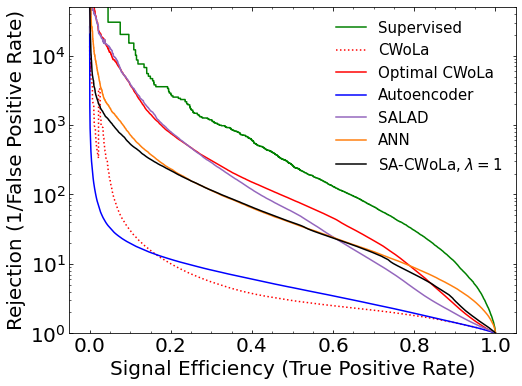

In [24]:
# Plot without banding
mylambda=.5
myklambda = 1 #np.round(len(SR_background_data)/len(SR_background_sim), 3)

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1])
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.yscale("log")
plt.ylim([1,5*1e4])
ERR=False
plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')

for band in bands:
    if band in ['old-sacwola', 'hl-sacwola']:
        continue
    mu,std = bands[band][3:5]

    plt.plot(tpr_pts, mu, **bands[band][-1])
    if ERR:
        plt.fill_between(tpr_pts, mu - std, mu + std, alpha=.2, color=bands[band][-1]['color'])
#plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.legend(frameon=False,fontsize=15,loc="upper right")

# plt.title("Correlated LHCO Example\n(Median of {} models)".format(n_injections),fontsize=20,)
plt.savefig('C:/Users/knukl/Desktop/FINAL/plots/combined_corr_deltamj_extracorr.pdf', pdf=True, bbox_inches='tight')
plt.savefig('C:/Users/knukl/Desktop/FINAL/plots/combined_corr_deltamj_extracorr.png', pdf=False, bbox_inches='tight')
# plt.show()

C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1927625856.py:26: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(tpr_sup,tpr_sup/np.sqrt(tpr_sup),color="black",ls=":",label="Random")
C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1927625856.py:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pdf" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('C:/Users/knukl/Desktop/FINAL/plots/combined_relsigs_corr_deltamj_extracorr.pdf', pdf=True, bbox_inches='tight')
C:\Users\knukl\AppData\Local\Temp\ipykernel_10176\1927625856.py:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pdf" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('C:/Users/knukl/Desktop/FINAL/plots/combined_relsigs_corr_deltamj_extracorr.png', pdf=False, bbox_inches='tight')


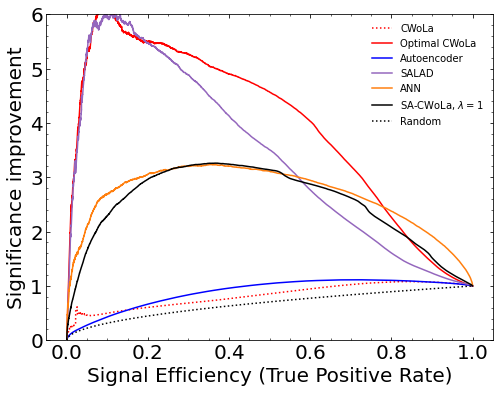

In [26]:
# Plot without banding
mylambda=.5
myklambda = 1 #np.round(len(SR_background_data)/len(SR_background_sim), 3)

ERR = False

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1])
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylim([0, 6])



for band in bands:
    if band in ['old-sacwola', 'hl-sacwola']:
        continue
    mu,std = bands[band][5:7]
    plt.plot(tpr_pts, tpr_pts*mu, **bands[band][-1])
plt.plot(tpr_sup,tpr_sup/np.sqrt(tpr_sup),color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Significance improvement",fontsize=20)
plt.legend(frameon=False,fontsize=10,loc="upper right")
#plt.title(r'$LHC$ $Olympics$ $Example$', loc='right', fontsize=20)

plt.savefig('C:/Users/knukl/Desktop/FINAL/plots/combined_relsigs_corr_deltamj_extracorr.pdf', pdf=True, bbox_inches='tight')
plt.savefig('C:/Users/knukl/Desktop/FINAL/plots/combined_relsigs_corr_deltamj_extracorr.png', pdf=False, bbox_inches='tight')